**Реализована калибровка датчиков по формуле (current-min)/(max-min). После реализации стабильно проходит линию на 13 скорости**

#### Исходные данные

* KP = 0.3
* KD = 1
* KI = 0
* MAX_OUT = 30
* SPEED_POWER = 13
* SLEEP_TIME = 1 / 1_000_000 * 10
* TARGET_VALUE_LEFT = 0
* TARGET_VALUE_RIGHT = 0

#### Что улучшило результаты
* Калибровка датчиков по формуле (current-min)/(max-min

#### Что пробоверено и не привело к улучшениям:
* Минимальное значение выходной величины - есть эффект на повортах, но дестабилизирует на прямой. В целом кажется тупиковой веткой.

#### Что не проверено:

* Обрабатывать отрицательный PID при приближении к нулю
* Сделать более точную калибровку
* Выставить правильный период изменения сейчас dt всегда 1
* Не усиливать P значением D, а только гасить 
* Получать значение по среднему из трех измерений


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loader import load_data 
sys.path.append("../src")
from alphabot.pid_module import PidController

In [2]:

data = load_data('./data/8_success_12_speed_sensor_normalization/2022-03-13_11:53:53.log')
sensor0=data['sensor0']
sensor1=data['sensor1']
sensor2=data['sensor2']
sensor3=data['sensor3']
sensor4=data['sensor4']
left_pid_out = data['left_pid_out']
right_pid_out = data['right_pid_out']
tm = data['tm']
actual_right_pid_out = []
print(len(tm))
dt_in_ms = np.diff(tm)/1_000_000
print(dt_in_ms)


6600
[1.704543 1.551445 1.59675  ... 1.607543 1.61012  1.502945]


### Сделаем анализ распределения времени между итерациями. В каждой итерации замер и формирование управляющего воздействия.

На диаграмме распределения видно, что в основном измерения проходят от 1,4 до 2,5 миллисекунд. На временной диаграмме видно, что периодичеки возникают единичные задержки до 5 миллисекунд. Задержки возникают каждые 100 измерений. Буфер для метрик установлен в 100. Задержки возникают при записи метрик на диск.

### Проведем анализ прохода по линии

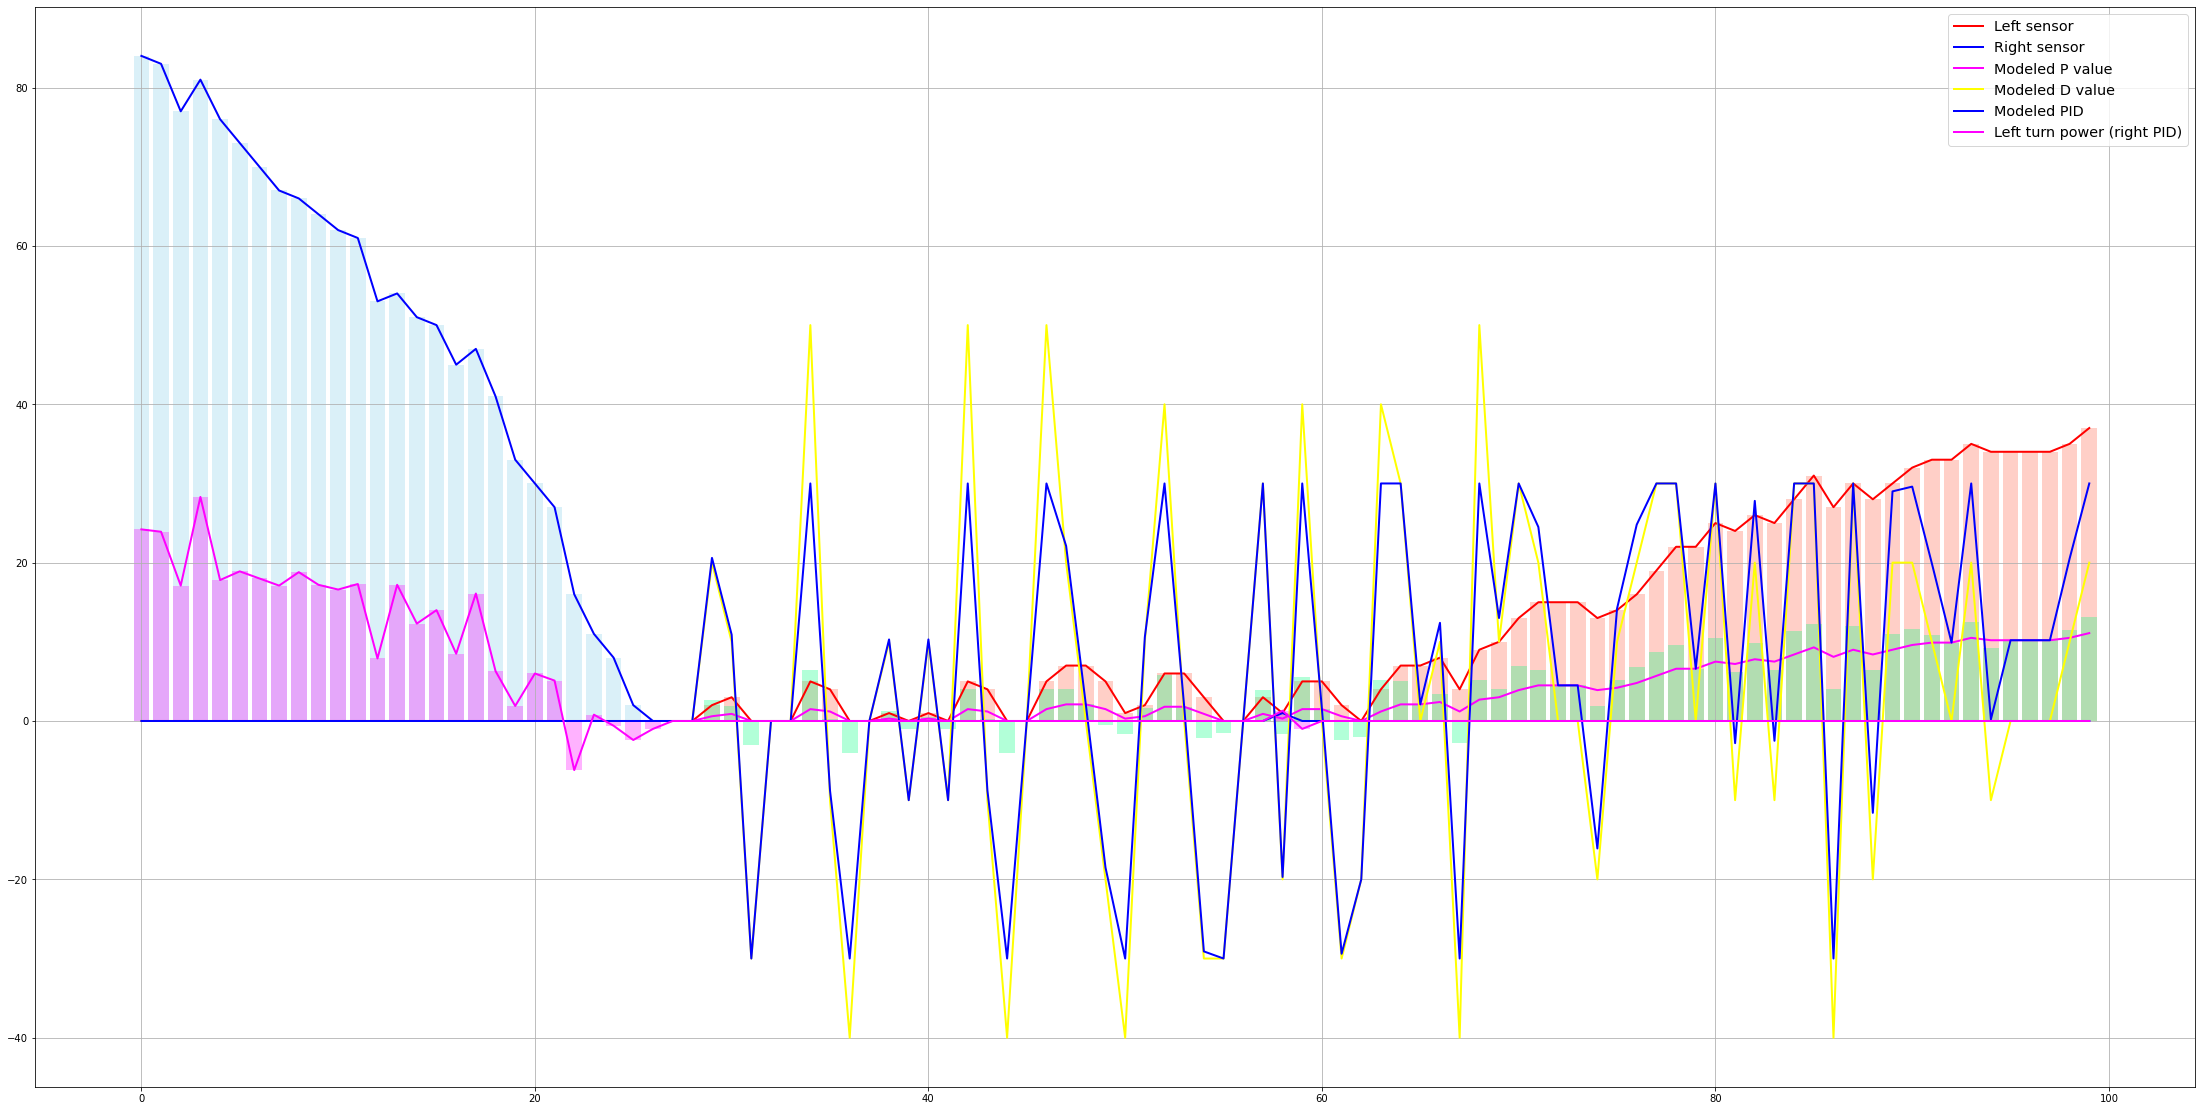

In [23]:
for i in range(0, len(left_pid_out),1):
    if left_pid_out[i] > 0 and right_pid_out[i]>0:
        if left_pid_out[i] > right_pid_out[i]:
            right_pid_out[i] = 0
        elif right_pid_out[i] > left_pid_out[i]:
            left_pid_out[i] = 0  

range_len = 100
start = 1660
end = start + range_len


KP = 0.3
KD = 10
KI = 0
MAX_OUT = 30
TARGET_VALUE_LEFT = 0
TARGET_VALUE_RIGHT = 0
pid = PidController(KP, KI, KD, TARGET_VALUE_LEFT, MAX_OUT)

p_out,d_out,i_out,pid_out = [],[],[],[]

for x in sensor1:
    pd_out = pid.getOutput(x, 1)*-1
    p_out.append(pid._telemetry_data['po']*-1)
    d_out.append(pid._telemetry_data['do']*-1)
    i_out.append(pid._telemetry_data['io']*-1)
    pid_out.append(pid._telemetry_data['o']*-1)
    
   


fig = plt.figure(figsize=(30, 15))
ax = fig.add_axes([0,0,1,1])


ax.plot(sensor1[start:end], linewidth=2.0, color = 'red', label='Left sensor')
ax.bar(np.arange(0,range_len,1), sensor1[start:end], color = 'tomato', alpha = 0.3)
ax.plot(sensor3[start:end], linewidth=2.0, color = 'blue', label = 'Right sensor')
ax.bar(np.arange(0,range_len,1), sensor3[start:end], color = 'skyblue', alpha = 0.3)


ax.plot(p_out[start:end], linewidth=2.0, color = 'magenta', label = 'Modeled P value')
ax.plot(d_out[start:end], linewidth=2.0, color = 'yellow', label = 'Modeled D value')
ax.plot(pid_out[start:end], linewidth=2.0, color = 'blue', label = 'Modeled PID')


#ax.plot(left_pid_out[start:end], linewidth=2.0, color = 'green', label = 'Right turn power (left PID)')
ax.bar(np.arange(0,range_len,1), left_pid_out[start:end], alpha = 0.3, color = 'springgreen')

ax.plot(right_pid_out[start:end], linewidth=2.0, color = 'magenta', label = 'Left turn power (right PID)')
ax.bar(np.arange(0,range_len,1), right_pid_out[start:end], alpha = 0.3, color = 'magenta')
ax.legend(fontsize = 'x-large')
ax.grid(True)
